<h1 style="text-align: center;" markdown="1">Multi-head attention</h1>



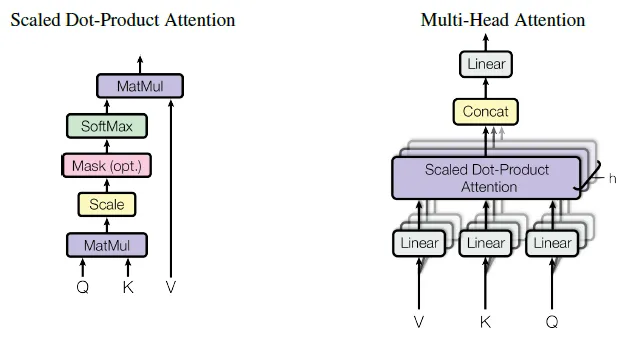


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4 # My name is Ankit
batch_size = 1 # number of sentences in batch
input_dim = 512 # vector dimension of each input
d_model = 512 # vector dimension of each output  of each attention unit       
x = torch.rand((batch_size, sequence_length, input_dim)) # input tensor

In [3]:
x.size() # batch_size X seq_len X input_dim

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3*d_model) # here we are concatenating q, k, v in one matrix which will be split later

In [5]:
qkv_layer # takes 512 input features and return 1536 output values. 

Linear(in_features=512, out_features=1536, bias=True)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv.shape # here we can see that each word vector is 3*512 -> 1536 in size

torch.Size([1, 4, 1536])

In [8]:
qkv

tensor([[[-0.8433,  0.1732, -0.7151,  ..., -0.0430, -0.0704,  0.4759],
         [-0.7403,  0.3404, -0.5212,  ...,  0.1204, -0.2584, -0.1166],
         [-0.7196,  0.3776, -0.4324,  ..., -0.1049, -0.4084,  0.1569],
         [-0.7859,  0.2743, -0.4968,  ..., -0.3206, -0.1705,  0.0801]]],
       grad_fn=<ViewBackward0>)

In [9]:
num_heads= 8 # now we have 8 attention head
head_dim= d_model//num_heads # each head will have dim of 512 / 8 => 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [10]:
qkv.shape # (1 sentence in a batch, each seq of length 4, 8 attention heads, q+k+v (64+64+64) is 192)

torch.Size([1, 4, 8, 192])

In [11]:
# let's change sequencing in qkv just to make things easy in future and perform parallel operations of last 2 dimensions
qkv=qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

## Self Attention for multiple heads

**For single head**
<!-- 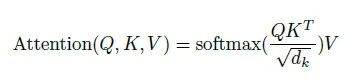 -->

<!-- self attention = softmax( ((Q.K^T)/d_k^0.5) + M)

new V = self attention . V -->

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$


In [13]:
import math
d_k = q.size()[-1] # get size of one of these vectors
d_k

64

In [14]:
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k) # (4*64) X (64*4) = (4*4)
scaled.shape

torch.Size([1, 8, 4, 4])

In [15]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [16]:
(scaled+mask)[0][0] # This is the tensor for one head that is 4 X 4 matrix

tensor([[ 0.1264,    -inf,    -inf,    -inf],
        [ 0.0019,  0.0968,    -inf,    -inf],
        [ 0.0493,  0.1366,  0.0264,    -inf],
        [-0.0439,  0.0379, -0.0045,  0.0591]], grad_fn=<SelectBackward0>)

In [17]:
scaled+=mask

In [18]:
attention = F.softmax(scaled, dim = -1) # dim = -1 means softmax is applied on last dimension i.e 4 out of [1,8,4,4]

In [19]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4763, 0.5237, 0.0000, 0.0000],
        [0.3259, 0.3556, 0.3185, 0.0000],
        [0.2362, 0.2563, 0.2457, 0.2618]], grad_fn=<SelectBackward0>)

In [20]:
values = torch.matmul(attention, v) # this value vector will be much more context aware then the input vectors.
values.shape

torch.Size([1, 8, 4, 64])